# The Case for Bike Lanes
### _The effect of bike lanes on traffic safety in Toronto_
#### Joseph Tadros
#
# Introduction
 The provincial government of Ontario recently announced plans to remove bike lanes from Bloor St, Yonge St, and University Ave in downtown Toronto, along with a new policy that would mean that cities in the province must obtain permission from the province before adding new bike lanes. The reason cited for these changes is that bike lanes cause traffic, according to Premier Doug Ford and Transportation Minister Prabmeet Sarkaria. Many have also taken to social media claiming that bikes are a a danger for drivers and that they don't belong on the road. This begs the question; are bike lanes really a danger for Toronto's streets? Or is the real problem an overreliance on cars? Using data obtained from Toronto's Open Data Portal, I will compare collision rates in regions of Toronto with and without bike lanes to answer this. I will also look at who's really involved in the most collisions, where the most dangerous collisions occur, and how collision rates have changed over time.
 #
![Alt text](https://www.toronto.ca/wp-content/uploads/2017/11/882d-Woodbine-Bike-Lanes-e1510154781892.jpg)
#
*Image Source: https://www.toronto.ca/wp-content/uploads/2017/11/882d-Woodbine-Bike-Lanes-e1510154781892.jpg*


## Analyses
I'll be looking at collision data from the city of Toronto, which is a good indication of traffic safety and is tied to congestion rates. I'll compare collisions rates on Bloor, Yonge, and University over time, and contrast these with the rest of the city. I'll also compare collisions which involve cyclists with those which don't, and geographic data about collision rates and types

### Data Collection & Cleaning

In [16]:
# import libraries to be used
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast 

 _Motor Vehicle Collisions involving Killed or Seriously Injured Persons_ is a free online dataset from [Toronto's Open Data Portal](https://open.toronto.ca/dataset/motor-vehicle-collisions-involving-killed-or-seriously-injured-persons/). Previously, I modified the dataset to remove alternating entries in order bring it down to a manageable size. It also contains many columns which aren't of interest for this exploration, so I have removed these as well

In [17]:
# read the data from the file into a dataframe
collisions = pd.read_csv("Motor Vehicle Collisions with KSI Data - 4326 (1).csv")

In [18]:
# remove certain columns I wont be needing
collisions = collisions.drop(columns=['_id', 'ACCNUM', 'OFFSET', 'ROAD_CLASS', 'ACCLOC', 'PEDESTRIAN', 'AUTOMOBILE', 'TRAFFCTL','INVTYPE','INVAGE','INJURY','FATAL_NO','INITDIR','MANOEUVER','DRIVACT','PEDTYPE','PEDACT','PEDCOND', 'HOOD_140', 'NEIGHBOURHOOD_140', 'DIVISION', 'STREET2', 'CYCLISTYPE', 'CYCACT', 'MOTORCYCLE','TRUCK','TRSN_CITY_VEH','EMERG_VEH', 'PASSENGER', 'CYCLIST', 'REDLIGHT', 'DISABILITY'])

Next, I renamed some of the remaining columns for readability, converted the 'date' column to datetime format for easier manipulation, and extracted longitude and latitdue from the 'coords' column 

In [19]:
# rename columns
collisions = collisions.rename(columns={"RDSFCOND" : "CONDITION", "geometry" : "COORDS", "NEIGHBOURHOOD_158" : "NEIGHBOURHOOD"})

# convert date format
collisions['DATE'] = pd.to_datetime(collisions['DATE'])

# convert COORDS column to new, seperate longitude and latitude columns
# Function to extract coordinates as a tuple (longitude, latitude)
def extract_coordinates(geometry):
    parsed = ast.literal_eval(geometry)  # parse the string as a dictionary
    coords = parsed["coordinates"][0]  # Extract coords
    return tuple(coords)

# Update the COORDS column to hold Long and Lat
collisions["COORDS"] = collisions["COORDS"].apply(extract_coordinates)

# Separate Long and Lat into seperate columns
collisions[["LONG", "LAT"]] = pd.DataFrame(collisions["COORDS"].tolist(), index=collisions.index)

### Distributions
First, we'll look at how collisions involving cyclists compare to other types of accidents


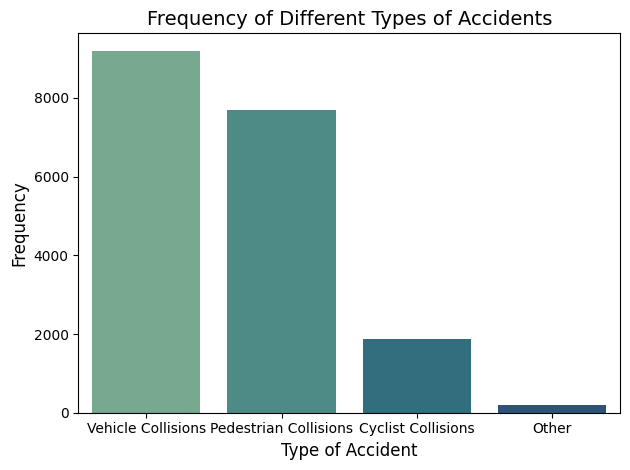

In [20]:
# get a count of each collision type, combining all vehicle-on-vehicle collisions
impact_counts = collisions['IMPACTYPE'].replace({'Turning Movement' : 'Vehicle Collisions', 
                                                 'Rear End' : 'Vehicle Collisions', 
                                                 'SMV Other' : 'Vehicle Collisions', 
                                                 'Angle' : 'Vehicle Collisions', 
                                                 'Approaching' : 'Vehicle Collisions', 
                                                 'Sideswipe' : 'Vehicle Collisions',
                                                 'SMV Unattended Vehicle' : 'Vehicle Collisions',  }).value_counts()

# save impact counts into a new dataframe and plot
impacts = impact_counts.reset_index()
impacts.columns = ['Impact Type', 'Frequency']

sns.barplot(data = impacts, x = 'Impact Type', y = 'Frequency', hue = 'Impact Type', palette = 'crest')

# Add labels and title
plt.xticks(fontsize = 10)
plt.title("Frequency of Different Types of Accidents", fontsize = 14)
plt.xlabel("Type of Accident", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.tight_layout()
plt.show()

This reveals that cyclists are involved in nearly 75% less collisions than pedestrians, despite directly sharing the road with cars, often without a designated bike lane

Next, I wanted to look at how the three roads being targeted for bike lane removal (Yonge, Bloor, & University) compare to other streets in terms of traffic safety. The figure below shows a rolling average for collision rates on the three listed roads with certain similarly sized roads which dont have bike lanes (Lake Shore, Dundas West, & Queen East) since 2007:

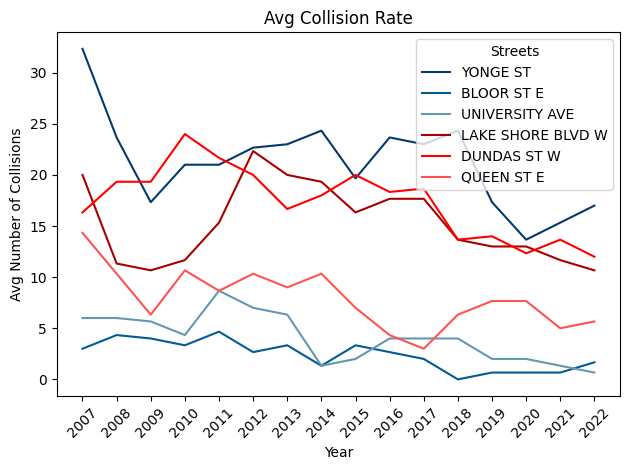

In [21]:
# List of streets to be plotted
streets_to_plot = ["YONGE ST", "BLOOR ST E", "UNIVERSITY AVE", "LAKE SHORE BLVD W", "DUNDAS ST W", "QUEEN ST E" ] 
filtered_data = collisions[collisions['STREET1'].isin(streets_to_plot)].copy()

# Group by street and year
filtered_data['Year'] = filtered_data['DATE'].dt.to_period('Y')
collision_counts = (filtered_data.groupby(['STREET1', 'Year']).size().reset_index(name='Collision Count'))

# Pivot data by year
pivot_data = collision_counts.pivot(index = 'Year', columns = 'STREET1', values = 'Collision Count').fillna(0)

# Add a rolling average to smooth the data
smoothed_data = pivot_data.rolling(window = 3, center = True).mean()

# Set streets w/ bike lanes to blue, streets w/o bike lanes to red
street_colors = {
    "YONGE ST": "#03396c",
    "BLOOR ST E": "#005b96",
    "UNIVERSITY AVE": "#6497b1",
    "LAKE SHORE BLVD W": "#a70000",
    "DUNDAS ST W": "#ff0000",
    "QUEEN ST E": "#ff5252"
}

# Plot smoothed data for each street
for street in streets_to_plot:
    plt.plot(smoothed_data.index.astype(str), smoothed_data[street], label = street, color = street_colors.get(street, 'gray'))

# labels and title
plt.title("Avg Collision Rate")
plt.xlabel("Year")
plt.ylabel("Avg Number of Collisions")
plt.xticks(rotation=45)
plt.legend(title="Streets")
plt.tight_layout()
plt.show()


Notably, despite seeing the largest decline in collision rates of the six examined roads (cutting it's average number of collisions in half), Yonge St still has the highest rate of the roads being compared. However, this could be attributed to it's sheer length and prominence in Downtown Toronto giving it much higher traffic rates in general. Outside of this, all of the streets examined have shown a decline in collisions since 2007, and University Ave and Bloor St both showed much lower collision rates than the selected non-bike lane roads. 

To understand how geography plays into collision rates, lets compare a heatmap of the collisions to a map of Toronto's bike network (bike insfrastructure other than bike lanes, like dedicated trails, are also included):

In [22]:
# get statistics for longitude
long_stats = collisions.LONG.describe()
long_stats

count    18957.000000
mean       -79.396490
std          0.104484
min        -79.638390
25%        -79.471469
50%        -79.397388
75%        -79.318286
max        -79.122974
Name: LONG, dtype: float64

In [23]:
# get statistics for latitude and save means of both longitude and latitude
lat_stats = collisions.LAT.describe()
avg_long, avg_lat = long_stats['mean'], lat_stats['mean']
lat_stats

count    18957.000000
mean        43.710299
std          0.056294
min         43.589678
25%         43.661727
50%         43.702346
75%         43.755945
max         43.855445
Name: LAT, dtype: float64

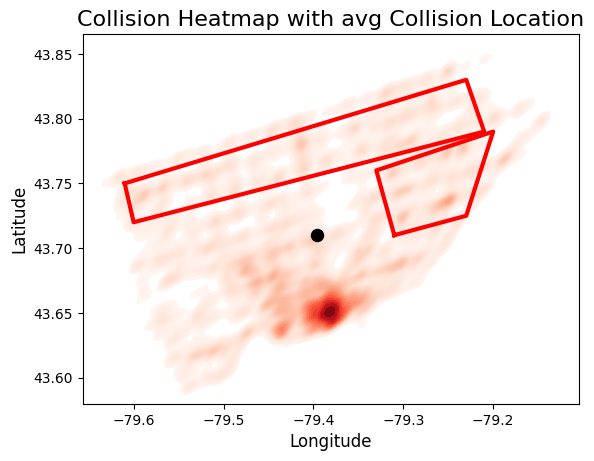

In [24]:
# generate heatmap using seaborn
sns.kdeplot(x = collisions["LONG"], y = collisions["LAT"], fill = True, cmap = "Reds", bw_adjust = 0.3, levels = 100)

# set x and y coords for scarborough hotspot
sx_coords = [-79.31, -79.23, -79.2, -79.33, -79.31]
sy_coords = [43.71, 43.725, 43.79, 43.76, 43.71]

# set x and y coords for northen hotspot
nx_coords = [-79.61, -79.23, -79.21, -79.6, -79.61]
ny_coords = [43.75, 43.83, 43.79, 43.72, 43.75]

# draw polygons on top of heatmap
plt.plot(sx_coords, sy_coords, color="red", linewidth=3)
plt.plot(nx_coords, ny_coords, color="red", linewidth=3)

# use average latitude and longitude to plot point on map
plt.scatter(avg_long, avg_lat, color = "black", s = 75)


plt.title("Collision Heatmap with avg Collision Location", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.show()

In the figure above, we can see that, predictably, the high-density downtown core has by far the highest collision rates. However, there are also notable hotspots in the north of the city along Finch and Steeles Aves, and throughout most of Scarborough in the east. Comparing this with the below map of Toronto's bike lanes, we can see that these regions correspond with some of the least developed bike infrastructure in the city:

<iframe src="https://www.google.com/maps/d/embed?mid=1v6FHIX4ccsbJOApmA9Rtn0bqdcw&ehbc=2E312F" width="640" height="480"></iframe>
#


*Embedded map source: https://bikingtoronto.com/maps/bikelanes*

Finally, if we look to a comparison of the severity of the collisions in Toronto's different regions:

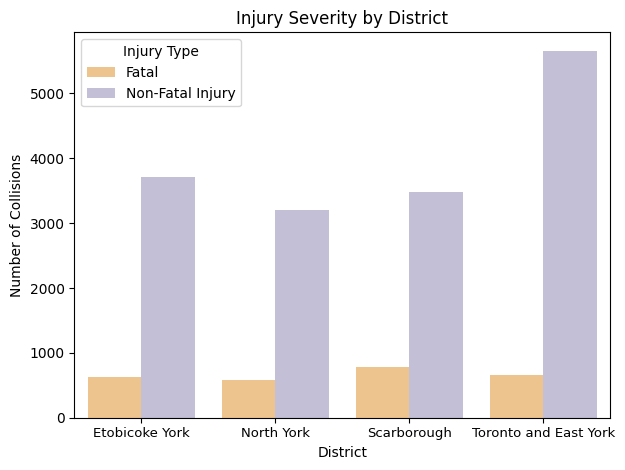

In [25]:
districts = ['Etobicoke York', 'Scarborough', 'Toronto and East York', 'North York']

# group data by quantity of each type of injury for each district
grouped_data = collisions.groupby(['DISTRICT', 'ACCLASS']).size().reset_index(name='Collision Count')

# filter to ensure only collisions with district data are included, exclude the 'property damage' class of accident
filtered_data = grouped_data[(grouped_data['DISTRICT'].isin(districts)) & (grouped_data['ACCLASS'] != 'Property Damage O')]

sns.barplot( data = filtered_data, x = 'DISTRICT', y = 'Collision Count', hue = 'ACCLASS', palette = 'PuOr')
plt.title('Injury Severity by District')
plt.xlabel('District')
plt.ylabel('Number of Collisions')
plt.xticks(fontsize = 9.5)
plt.legend(title='Injury Type')
plt.tight_layout()
plt.show()


We see that, although possessing much higher collision rates in general, the region of Toronto encompassing the city's downtown actually has a similar number of fatal collisions to each other region. This means that, proportionally, North York and Scarborough have more dangerous collisions on average. This is likely owing to the fact that these regions are more sprawling in nature, which means less bike infrastructure and a higher dependance on cars and high-speed roads. These factors make a region inherently more dangerous for cars, pedestrians, and cyclists.

## Discussion
In this exploration of the relationship between bike infrastructrure and traffic safety, we found that collisions involving cars and pedestrians are far more prevalent in Toronto than those involving cyclists. We also saw that collision rates as a whole have been declining, especially on the roads with bike lanes which are being targeted for removal. Although more densely populated areas like Downtown Toronto, which have the most bike lanes, also possessed the highest overall collision rates, these collisions are also comparatively less severe than those occuring where cycling is less encouraged and the population is more car-dependent, in regions like Scarborough and North York. These findings all point to bike lanes _helping_ traffic safety, not hurting it. Instead of blaming bike lanes for congestion and dangerous roads, it may be beneficial to instead look to them as an alternative to driving, in order to reduce our reliance on cars. This would not only improve safety for all road users - especially pedestrians, who were involved in a disproportionally large share of collisions - but also aid the city in reducing CO2 emmisions going forward.

## References
1. Source data - https://open.toronto.ca/dataset/motor-vehicle-collisions-involving-killed-or-seriously-injured-persons/
2. Pandas for data manipulation
3. Ast for dictionary manipulation
4. Seaborn for data visualization
5. Matplotlib for data visualization